# Importar librerias necesarias

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
import os

# Definicion de funciones
- find_countours encuentra las diferentes letras dentro de una imagen y devuelve un array con los characters encontrados
- segment_characters prepara la imagen para pasarsela a find_contours

In [2]:
def find_contours(dimensions, img) :
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    ii = cv2.imread('temp.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) 
            char_copy = np.zeros((44,24))
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            char = cv2.subtract(255, char)


            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy)
            
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])
    img_res = np.array(img_res_copy)

    return img_res


In [3]:
def segment_characters(path):
    image = cv2.imread(path)

    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    dimensions = [LP_WIDTH/6, LP_WIDTH/2, LP_HEIGHT/10, 2*LP_HEIGHT/3]
    plt.show()
    cv2.imwrite('temp.jpg',img_binary_lp)

    char_list = find_contours(dimensions, img_binary_lp)
    os.remove('temp.jpg') 
    return char_list

Ejemplo del funcionamiento de las funciones

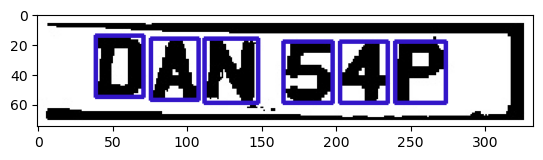

In [4]:
char = segment_characters("./ejemplo1.jpg")

# Se crean los data generators para poder leer las imagenes del set de train y de test

In [5]:
import tensorflow.keras.backend as K
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = "D:\\Universidad\\InteligenciaArtificial\\tp\\dataset-separated"
train_generator = train_datagen.flow_from_directory(
        path+'\\train', 
        target_size=(28,28),
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'\\test',
        target_size=(28,28),
        class_mode='sparse')

Found 777 images belonging to 36 classes.
Found 336 images belonging to 36 classes.


# Se crea y se entrena el modelo 
La explicación de la arquitectura de la red está en el documento del trabajo

In [6]:
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])

In [7]:
batch_size = 1
model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size, 
      validation_data = validation_generator, 
      epochs = 30, verbose=1)

Epoch 1/30
777/777 [==============================] - 14s 18ms/step - loss: 3.1818 - accuracy: 0.1467 - val_loss: 2.7334 - val_accuracy: 0.2321
Epoch 2/30
777/777 [==============================] - 13s 17ms/step - loss: 2.4620 - accuracy: 0.3269 - val_loss: 1.9668 - val_accuracy: 0.4256
Epoch 3/30
777/777 [==============================] - 13s 17ms/step - loss: 1.7814 - accuracy: 0.5251 - val_loss: 1.4034 - val_accuracy: 0.5804
Epoch 4/30
777/777 [==============================] - 13s 17ms/step - loss: 1.2768 - accuracy: 0.6538 - val_loss: 1.1658 - val_accuracy: 0.7054
Epoch 5/30
777/777 [==============================] - 13s 17ms/step - loss: 0.9266 - accuracy: 0.7259 - val_loss: 0.8135 - val_accuracy: 0.7798
Epoch 6/30
777/777 [==============================] - 14s 18ms/step - loss: 0.7626 - accuracy: 0.7825 - val_loss: 0.6162 - val_accuracy: 0.8363
Epoch 7/30
777/777 [==============================] - 13s 17ms/step - loss: 0.6067 - accuracy: 0.8275 - val_loss: 0.5143 - val_accuracy:

# Definicion de funciones
- fix_dimension es para reajustar el tamaño de la imagen antes de pasarsela al modelo
- show_results sirve predecir cada uno de las imágenes que hay en la lista que recibe por parametro, en cada prediccion guarda el resultado (un char) en un array, luego hace un concat y devuelve la predicción de la patente completa

In [8]:
def fix_dimension(img): 
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img

In [9]:
def show_results(char_list):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char_list):
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3)
        y = model.predict(img)[0]
        character = dic[np.where(y==1)[0][0]]
        output.append(character)
        
    plate_number = ''.join(output)
    
    return plate_number

# Se revisa la métrica para evaluar el rendimiento del modelo

In [10]:
_,acc = model.evaluate(validation_generator, steps=len(validation_generator),verbose=0)
print("> %.3f" % (acc * 100))

> 91.369


# Ejemplos de predicciones

1/1 [==============================] - 0s 24ms/step


'DAN54P'

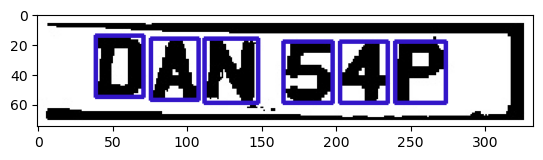

In [12]:
show_results(segment_characters("./ejemplo1.jpg"))

1/1 [==============================] - 0s 25ms/step


'778393'

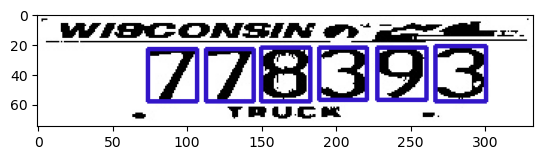

In [13]:
show_results(segment_characters("./ejemplo2.jpg"))

1/1 [==============================] - 0s 23ms/step


'129527F'

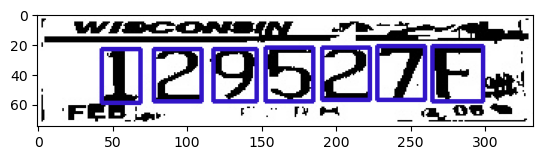

In [14]:
show_results(segment_characters("./ejemplo3.jpg"))